Install the tools

In [1]:
#!pip install torch numpy==1.23.5 matplotlib gym==0.25.2 pygame

https://www.datacamp.com/tutorial/proximal-policy-optimization

Import the packages in Python

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torch.distributions as distributions
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import gym


Create two environments - for training and testing

In [3]:
env_train = gym.make('CartPole-v1')
env_test = gym.make('CartPole-v1')#,render_mode='human'


/opt/anaconda3/envs/ppo/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/envs/ppo/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Create the backbone network

Define the actor-critic model

In [4]:
class Critic(nn.Module):
    def __init__(self, in_features, hidden_dimensions, out_features, dropout):
        super().__init__()

        self.layer1 = nn.Linear(in_features, hidden_dimensions)
        self.layer2 = nn.Linear(hidden_dimensions, hidden_dimensions)
        self.layer3 = nn.Linear(hidden_dimensions, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer1(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x


class Actor(nn.Module):
    def __init__(self, in_features, hidden_dimensions, out_features, dropout):
        super().__init__()

        self.layer1 = nn.Linear(in_features, hidden_dimensions)
        self.layer2 = nn.Linear(hidden_dimensions, hidden_dimensions)
        self.layer3 = nn.Linear(hidden_dimensions, out_features)
        self.dropout = nn.Dropout(dropout)
        self.Softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.layer1(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        action_prob = self.Softmax(x)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        return action, log_prob_action, dist


Create an agent

In [5]:
def create_agent(hidden_dimensions, dropout):
    INPUT_FEATURES = env_train.observation_space.shape[0]
    HIDDEN_DIMENSIONS = hidden_dimensions
    ACTOR_OUTPUT_FEATURES = env_train.action_space.n
    CRITIC_OUTPUT_FEATURES = 1
    DROPOUT = dropout

    actor = Actor(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, ACTOR_OUTPUT_FEATURES, DROPOUT)
    critic = Critic(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, CRITIC_OUTPUT_FEATURES, DROPOUT)
    return actor, critic


Define a function to calculate the returns from the rewards

In [6]:
def calculate_returns(rewards, discount_factor):
    returns = []
    cumulative_reward = 0
    for r in reversed(rewards):
        cumulative_reward = r + cumulative_reward * discount_factor
        returns.insert(0, cumulative_reward)

    returns = torch.tensor(returns)
    # normalize the return
    returns = (returns - returns.mean()) / returns.std()

    return returns


Define a function to calculate the advantages

In [7]:
def calculate_advantages(returns, values):
    advantages = returns - values
    # Normalize the advantage
    advantages = (advantages - advantages.mean()) / advantages.std()
    return advantages


Define a function to calculate surrogate losses

In [8]:
def calculate_surrogate_loss(
        actions_log_probability_old,
        actions_log_probability_new,
        epsilon,
        advantages):
    advantages = advantages.detach()
    policy_ratio = (
            actions_log_probability_new - actions_log_probability_old
            ).exp()
    surrogate_loss_1 = policy_ratio * advantages
    surrogate_loss_2 = torch.clamp(
            policy_ratio, min=1.0-epsilon, max=1.0+epsilon
            ) * advantages
    surrogate_loss = torch.min(surrogate_loss_1, surrogate_loss_2)
    return surrogate_loss


Define a function to calculate policy loss and value loss

In [9]:
def calculate_losses(
        surrogate_loss, entropy, entropy_coefficient, returns, value_pred):
    entropy_bonus = entropy_coefficient * entropy
    policy_loss = -(surrogate_loss + entropy_bonus).sum()
    value_loss = f.smooth_l1_loss(returns, value_pred).sum()
    return policy_loss, value_loss


Initialize a set of buffers to use during the training

In [10]:
def init_training():
    states = []
    actions = []
    actions_log_probability = []
    values = []
    rewards = []
    done = False
    episode_reward = 0
    return states, actions, actions_log_probability, values, rewards, done, episode_reward


Define the forward pass

In [11]:
def forward_pass(env, actor, critic, optimizer_actor,optimizer_critic, discount_factor):
    states, actions, actions_log_probability, values, rewards, done, episode_reward = init_training()
    state = env.reset()
    actor.train()
    critic.train()
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        states.append(state)

        action, log_prob_action, _ = actor(state)
        value_pred = critic(state)
        
        state, reward, done, _ = env.step(action.item())

        actions.append(action)
        actions_log_probability.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        episode_reward += reward

    states = torch.cat(states)
    actions = torch.cat(actions)
    actions_log_probability = torch.cat(actions_log_probability)
    values = torch.cat(values).squeeze(-1)
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)

    return episode_reward, states, actions, actions_log_probability, advantages, returns


Define the function to update the policy parameters

In [12]:
def update_policy(
        actor,
        critic,
        states,
        actions,
        actions_log_probability_old,
        advantages,
        returns,
        optimizer_actor,
        optimizer_critic,
        ppo_steps,
        epsilon,
        entropy_coefficient):

    BATCH_SIZE = 128
    total_policy_loss = 0
    total_value_loss = 0
    actions_log_probability_old = actions_log_probability_old.detach()
    actions = actions.detach()

    training_results_dataset = TensorDataset(
            states,
            actions,
            actions_log_probability_old,
            advantages,
            returns)

    batch_dataset = DataLoader(
            training_results_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False)

    for _ in range(ppo_steps):
        for batch_idx, (states, actions, actions_log_probability_old, advantages, returns) in enumerate(batch_dataset):
            # get new log prob of actions for all input states
            action, actions_log_probability_new, probability_distribution_new = actor(states) 
            value_pred = critic(states)
            value_pred = value_pred.squeeze(-1)
            entropy = probability_distribution_new.entropy()

            # estimate new log probabilities using old actions
            actions_log_probability_new = probability_distribution_new.log_prob(actions)
            surrogate_loss = calculate_surrogate_loss(
                    actions_log_probability_old,
                    actions_log_probability_new,
                    epsilon,
                    advantages)
            policy_loss, value_loss = calculate_losses(
                    surrogate_loss,
                    entropy,
                    entropy_coefficient,
                    returns,
                    value_pred)

            optimizer_actor.zero_grad() 
            optimizer_critic.zero_grad() 
            policy_loss.backward()
            value_loss.backward()
            optimizer_actor.step()
            optimizer_critic.step()
            # calculate the total loss
            # and add it to the total loss
            # for the current batch

            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()

    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps


Define a function to evaluate the model's (policy's) performance

In [13]:
def evaluate(env, actor):

    actor.eval()
    rewards = []
    done = False
    episode_reward = 0
    state = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action, log_prob_action, dist = actor(state)
        state, reward, done, _ = env.step(action.item())
        episode_reward += reward

    return episode_reward


Define a function to plot the rewards

In [14]:
def plot_train_rewards(train_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(train_rewards, label='Train Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Training Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(train_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [15]:
def plot_test_rewards(test_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(test_rewards, label='Test Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Testing Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(test_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


Define a function to plot the losses

In [16]:
def plot_losses(policy_losses, value_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(value_losses, label='Value Losses')
    plt.plot(policy_losses, label='Policy Losses')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [17]:
def evaluate_see(env, actor, render=False, print_model_info=False):
    """
    Avalia o modelo com opções de visualização
    
    Args:
        env: Ambiente Gym
        actor: Modelo do ator
        render: Se True, renderiza o ambiente
        print_model_info: Se True, mostra informações do modelo
    """
    actor.eval()
    episode_reward = 0
    state = env.reset()
    done = False
    
    if print_model_info:
        print("\n" + "="*50)
        print("Informações do Modelo durante Avaliação:")
        print(f"Nome: {actor.__class__.__name__}")
        print(f"Device: {next(actor.parameters()).device}")
        print(f"Parâmetros totais: {sum(p.numel() for p in actor.parameters()):,}")
        print("="*50 + "\n")

    step = 0
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
            action, log_prob_action, dist = actor(state_tensor)
            
            if print_model_info and step == 0:  # Mostra apenas no primeiro passo
                print(f"\nEstado de entrada (shape): {state_tensor.shape}")
                print(f"Distribuição de ações: {dist}")
                print(f"Ação selecionada: {action.item():.4f}")
                print(f"Log prob da ação: {log_prob_action.item():.4f}")
        
        state, reward, done, _ = env.step(action.item())
        episode_reward += reward
        step += 1
    
    if print_model_info:
        print(f"\nRecompensa total do episódio: {episode_reward:.2f}")
    
    return episode_reward

Define the main function to train and evaluate the model

In [20]:
def run_ppo():
    MAX_EPISODES = 300
    DISCOUNT_FACTOR = 0.99
    REWARD_THRESHOLD = 475
    PRINT_INTERVAL = 10
    PPO_STEPS = 8
    N_TRIALS = 100
    EPSILON = 0.2
    ENTROPY_COEFFICIENT = 0.01

    HIDDEN_DIMENSIONS = 64
    DROPOUT = 0.2
    LEARNING_RATE = 0.001

    train_rewards = []
    test_rewards = []
    policy_losses = []
    value_losses = []

    actor, critic = create_agent(HIDDEN_DIMENSIONS, DROPOUT)
    optimizer_actor = optim.Adam(actor.parameters(), lr=LEARNING_RATE)
    optimizer_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE)

    for episode in range(1, MAX_EPISODES+1):
        train_reward, states, actions, actions_log_probability, advantages, returns = forward_pass(
                env_train,
                actor,
                critic,
                optimizer_actor,
                optimizer_critic,
                DISCOUNT_FACTOR)
        policy_loss, value_loss = update_policy(
                actor,
                critic,
                states,
                actions,
                actions_log_probability,
                advantages,
                returns,
                optimizer_actor,
                optimizer_critic,
                PPO_STEPS,
                EPSILON,
                ENTROPY_COEFFICIENT)
        test_reward = evaluate(env_test, actor)

        policy_losses.append(policy_loss)
        value_losses.append(value_loss)
        train_rewards.append(train_reward)
        test_rewards.append(test_reward)

        mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
        mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
        mean_abs_policy_loss = np.mean((policy_losses[-N_TRIALS:]))
        mean_abs_value_loss = np.mean((value_losses[-N_TRIALS:]))

        if episode % PRINT_INTERVAL == 0:
            print(f'Episode: {episode:3d} | Training Reward: {train_reward:.1f} | '
                  f'Testing Reward: {test_reward:.1f} | '
                  f'Mean Train Rewards: {mean_train_rewards:.1f} | '
                  f'Mean Test Rewards: {mean_test_rewards:.1f} | '
                  f'Mean  Policy Loss: {mean_abs_policy_loss:.2f} | '
                  f'Mean  Value Loss: {mean_abs_value_loss:.2f} | '
                  f' Policy Loss: {policy_loss:.2f} | '
                  f'Value Loss: {value_loss:.2f} | ')
            

        if mean_test_rewards >= REWARD_THRESHOLD:
            print(f'Reached reward threshold in {episode} episodes')
            break

        if episode == (MAX_EPISODES-1):
            evaluate_see(env_test, actor, render=True, print_model_info=True)

    plot_train_rewards(train_rewards, REWARD_THRESHOLD)
    plot_test_rewards(test_rewards, REWARD_THRESHOLD)
    plot_losses(policy_losses, value_losses)  
    return actor


Run the main function

Episode:  10 | Training Reward: 12.0 | Testing Reward: 44.0 | Mean Train Rewards: 21.5 | Mean Test Rewards: 20.4 | Mean  Policy Loss: -0.26 | Mean  Value Loss: 0.35 |  Policy Loss: -0.17 | Value Loss: 0.11 | 
Episode:  20 | Training Reward: 26.0 | Testing Reward: 40.0 | Mean Train Rewards: 26.1 | Mean Test Rewards: 24.1 | Mean  Policy Loss: -0.32 | Mean  Value Loss: 0.37 |  Policy Loss: -0.19 | Value Loss: 0.33 | 
Episode:  30 | Training Reward: 17.0 | Testing Reward: 73.0 | Mean Train Rewards: 32.0 | Mean Test Rewards: 29.4 | Mean  Policy Loss: -0.24 | Mean  Value Loss: 0.38 |  Policy Loss: -0.06 | Value Loss: 0.21 | 
Episode:  40 | Training Reward: 37.0 | Testing Reward: 42.0 | Mean Train Rewards: 37.3 | Mean Test Rewards: 34.5 | Mean  Policy Loss: -0.20 | Mean  Value Loss: 0.35 |  Policy Loss: 0.35 | Value Loss: 0.16 | 
Episode:  50 | Training Reward: 85.0 | Testing Reward: 34.0 | Mean Train Rewards: 45.0 | Mean Test Rewards: 39.3 | Mean  Policy Loss: -0.25 | Mean  Value Loss: 0.37 

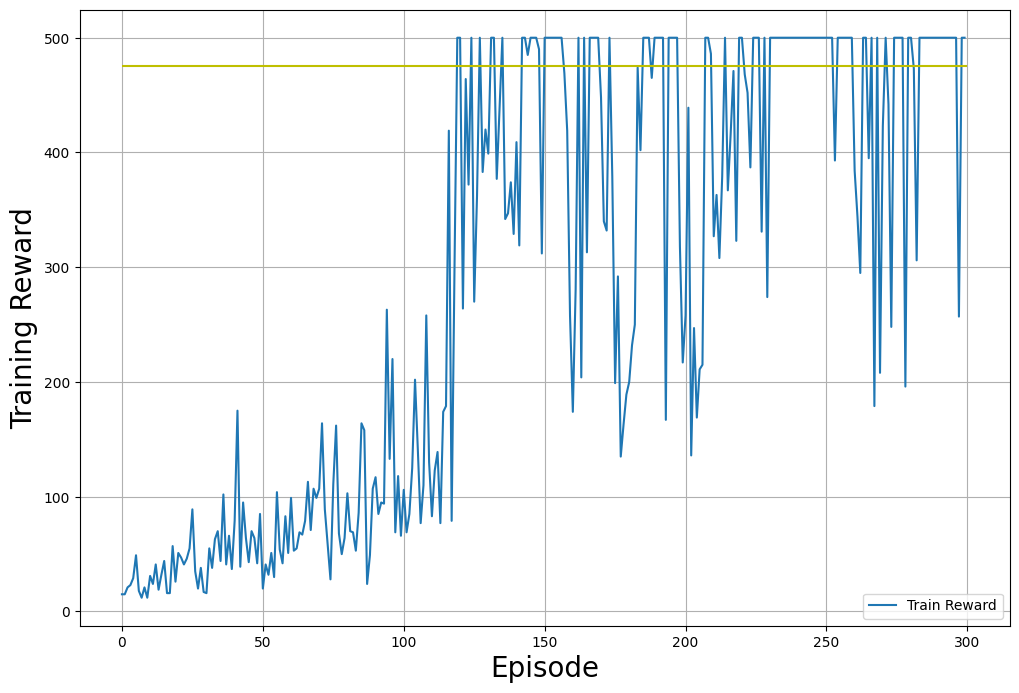

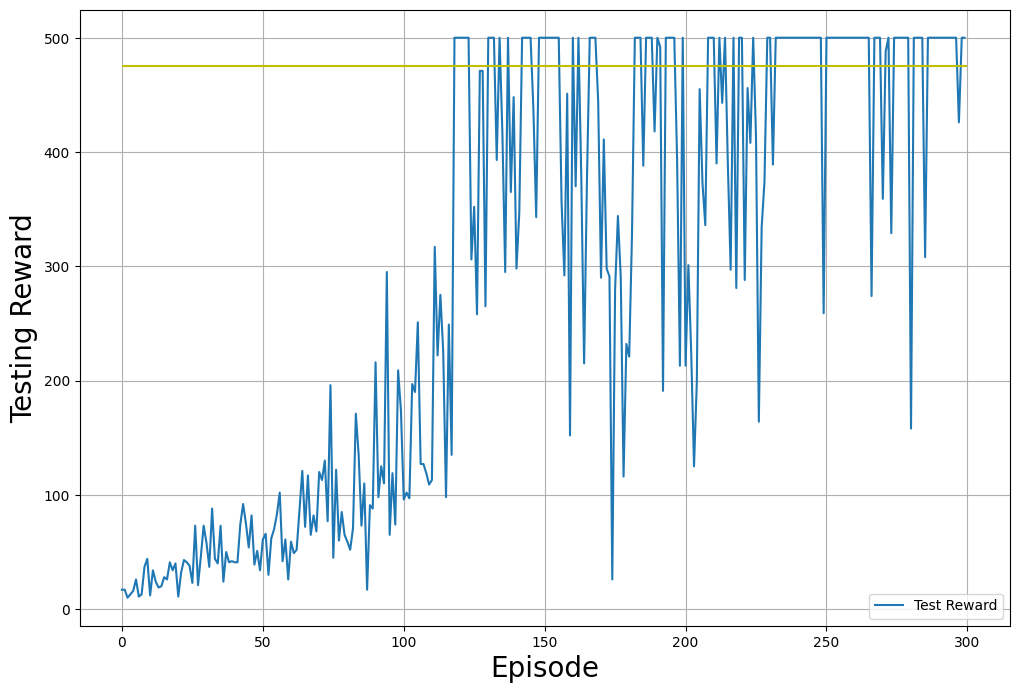

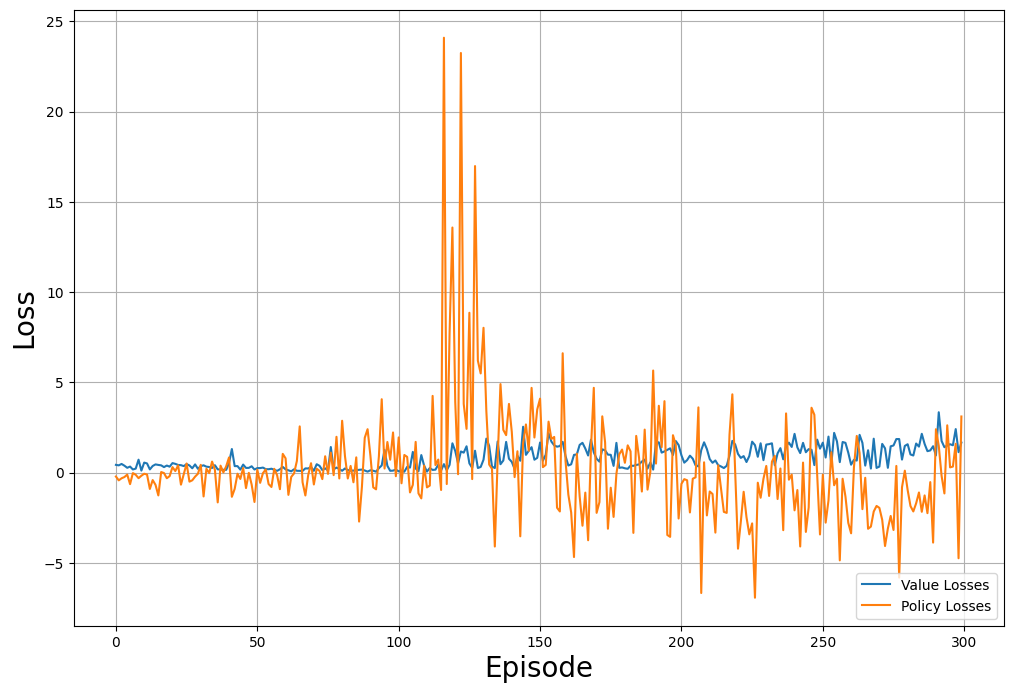

In [21]:
actor = run_ppo()

In [24]:
env = gym.make('CartPole-v1',render_mode='human')
evaluate_see(env, actor, render=True, print_model_info=True)

/opt/anaconda3/envs/ppo/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/envs/ppo/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Informações do Modelo durante Avaliação:
Nome: Actor
Device: cpu
Parâmetros totais: 4,610


Estado de entrada (shape): torch.Size([1, 4])
Distribuição de ações: Categorical(probs: torch.Size([1, 2]), logits: torch.Size([1, 2]))
Ação selecionada: 0.0000
Log prob da ação: -0.3298

Recompensa total do episódio: 500.00


500.0